In [1]:
import sys 
#sys.path.append("codes/modules") # add custom Vibe 's modules
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')

import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time
import pandas as pd
import xarray as xr
sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap

No joblib
no cmocean


In [2]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/scratch/usr/hbkoziel/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

tracername = 'LIM'
first_year = 1985
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc12'

data_path  = '/scratch/usr/hbkoziel/'+runid+'/netcdf_monthly/'

# Define local pass #
wd_path = '/home/hbkoziel/pyfesom/'
save_path = wd_path+'/figures/Arc12/FINAL2/'

/scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh


In [3]:
dates = pd.date_range('1985', freq="M", periods= 12*len(np.arange(1985,2016,1)))
data = xr.open_mfdataset(data_path+tracername+'*.nc', concat_dim='time')
data['time'] = dates
#data.time.data = dates

In [4]:
data

<xarray.Dataset>
Dimensions:            (nod2d: 753179, time: 372)
Coordinates:
  * time               (time) datetime64[ns] 1985-01-31 ... 2015-12-31
Dimensions without coordinates: nod2d
Data variables:
    Felimphy           (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
    Felimdia           (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
    Nlimphy            (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
    Nlimdia            (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
    Silim              (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
    Phy_Light_limiter  (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
    Dia_Light_limiter  (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
    Phy_Lim            (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(

In [ ]:
data2 = data.sel(time=data.time.dt.month.isin([7, 8, 9]))
data2 = data2.compute()

data2 = data2.resample(time='YS').mean(dim='time')
data2 = data2.compute()
data2

In [ ]:
# data2['Nlimphy'].plot()

In [ ]:
data_np = data2.Nlimphy.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
data_np = data_np.compute()

data_nd = data2.Nlimdia.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
data_nd = data_nd.compute()

data_si = data2.Silim.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
data_si = data_si.compute()

data_lp = data2.Phy_Light_limiter.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
data_lp = data_lp.compute()

data_ld = data2.Dia_Light_limiter.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
data_ld = data_ld.compute()

In [ ]:
print np.shape(data_np)

In [11]:
ncfile      = meshpath+'Arc4.5.initial.mesh.diag.nc'
f           = Dataset(ncfile, 'r')
NodalAreaModel = f.variables['cluster_area'][:]

In [12]:
print('loading index...')
df = pd.read_csv('/scratch/usr/hbkoziel/mesh/meshArc4.5/bioregion_index_latlon.csv', delimiter=',',header=0)
print('LOADING DONE')
df.sort_values(by ='Unique_ID',inplace=True)
index = df["Unique_ID"]
index_unique = df.Unique_ID.unique().tolist()
index_unique.pop(-1)
print('SORTING...')
names = df.Name.unique().tolist()
names.pop(-1)
names[3]='Beaufort Sea - shelf'
names[4]='Amundsen-Viscount'
names.append('All Arctic Ocean (>66N)')
print('DONE')

loading index...
LOADING DONE
SORTING...
DONE


In [13]:
factor = .4#.35

In [14]:
dates = pd.date_range('1985', freq="YS", periods= len(np.arange(1985,2016,1)))
ind_bio = df.full_index[df.Unique_ID == 24]
df2 = pd.DataFrame()
df3 = pd.DataFrame()

area_bio_np = np.zeros(len(data_np.time))
area_bio_nd = np.zeros(len(data_np.time))
area_bio_si = np.zeros(len(data_np.time))
area_bio_lp = np.zeros(len(data_np.time))
area_bio_ld = np.zeros(len(data_np.time))
area_bio_light = np.zeros(len(data_np.time))
area_bio_nut = np.zeros(len(data_np.time))

for i in range(0,len(data_np.time)):
    
    ind_np = np.intersect1d(np.where(data_np[i,:] <factor),ind_bio)
    ind_nd = np.intersect1d(np.where(data_nd[i,:] <factor),ind_bio)
    ind_si = np.intersect1d(np.where(data_si[i,:] <factor),ind_bio)
    ind_lp = np.intersect1d(np.where(data_lp[i,:] <factor),ind_bio)
    ind_ld = np.intersect1d(np.where(data_ld[i,:] <factor),ind_bio)
#     ind_nut = np.intersect1d(ind_np, ind_nd)
#     ind_nut = np.intersect1d(ind_nut,ind_si)
#     ind_light = np.intersect1d(ind_lp, ind_ld)
    #ind_nut = np.unique(np.concatenate((ind_np,ind_nd,ind_si),0))
    #ind_light = np.unique(np.concatenate((ind_lp,ind_ld),0))
    
    ind_light = np.where((data_np[i,:] >factor) & (data_nd[i,:] >factor) & (data_si[i,:]> factor) & (data_lp[i,:] <= factor) & (data_ld[i,:] <= factor))
    ind_light = np.intersect1d(ind_light,ind_bio)
    ind_nut = np.where((data_np[i,:] <= factor) | (data_nd[i,:] <= factor) | (data_si[i,:] <= factor))
    ind_nut = np.intersect1d(ind_nut,ind_bio)
    
    area_bio_np[i] = np.sum(NodalAreaModel[ind_np])
    area_bio_nd[i] = np.sum(NodalAreaModel[ind_nd])
    area_bio_si[i] = np.sum(NodalAreaModel[ind_si])
    area_bio_lp[i] = np.sum(NodalAreaModel[ind_lp])
    area_bio_ld[i] = np.sum(NodalAreaModel[ind_ld])
    area_bio_nut[i] = np.sum(NodalAreaModel[ind_nut])
    area_bio_light[i] = np.sum(NodalAreaModel[ind_light])
    
df2 = pd.DataFrame()
df2['time'] = dates
df2.set_index('time', inplace= True)
df2['area_np'] = area_bio_np
df2['area_nd'] = area_bio_nd
df2['area_si'] = area_bio_si
df2['area_lp'] = area_bio_lp
df2['area_ld'] = area_bio_ld
df2['light'] = area_bio_light
df2['nutrient'] = area_bio_nut

df3_yearly_em = df2.resample('Y').sum()

In [15]:
dates = pd.date_range('1985', freq="YS", periods= len(np.arange(1985,2016,1)))
ind_bio = df.full_index[df.Unique_ID == 25]
df2 = pd.DataFrame()
df3 = pd.DataFrame()

area_bio_np = np.zeros(len(data_np.time))
area_bio_nd = np.zeros(len(data_np.time))
area_bio_si = np.zeros(len(data_np.time))
area_bio_lp = np.zeros(len(data_np.time))
area_bio_ld = np.zeros(len(data_np.time))
area_bio_light = np.zeros(len(data_np.time))
area_bio_nut = np.zeros(len(data_np.time))

for i in range(0,len(data_np.time)):

    ind_np = np.intersect1d(np.where(data_np[i,:] <factor),ind_bio)
    ind_nd = np.intersect1d(np.where(data_nd[i,:] <factor),ind_bio)
    ind_si = np.intersect1d(np.where(data_si[i,:] <factor),ind_bio)
    ind_lp = np.intersect1d(np.where(data_lp[i,:] <factor),ind_bio)
    ind_ld = np.intersect1d(np.where(data_ld[i,:] <factor),ind_bio)
    #ind_light = np.intersect1d(np.where(data_ld[i,:] <.7 & data_lp[i,:] <.7 & data_np[i,:] >.7 & data_nd[i,:] >.7 & data_si[i,:] >.7),ind_bio)
    #ind_nut = np.intersect1d(np.where(data_ld[i,:] <.7 & data_lp[i,:] <.7 & data_np[i,:] >.7 & data_nd[i,:] >.7 & data_si[i,:] >.7),ind_bio)
    
    ind_light = np.where((data_np[i,:] > factor) & (data_nd[i,:] > factor) & (data_si[i,:] > factor) & (data_lp[i,:] <= factor) & (data_ld[i,:] <= factor))
    ind_light = np.intersect1d(ind_light,ind_bio)
    ind_nut = np.where((data_np[i,:] <= factor) | (data_nd[i,:] <= factor) | (data_si[i,:]<= factor))
    ind_nut = np.intersect1d(ind_nut,ind_bio)
    
    #ind_nut = np.intersect1d(ind_np, ind_nd)
    #ind_nut = np.intersect1d(ind_nut,ind_si)
    #ind_light = np.intersect1d(ind_lp, ind_ld)
    
    #ind_nut = np.unique(np.concatenate((ind_np,ind_nd,ind_si),0))
    #ind_light = np.unique(np.concatenate((ind_lp,ind_ld),0))
    
    area_bio_np[i] = np.sum(NodalAreaModel[ind_np])
    area_bio_nd[i] = np.sum(NodalAreaModel[ind_nd])
    area_bio_si[i] = np.sum(NodalAreaModel[ind_si])
    area_bio_lp[i] = np.sum(NodalAreaModel[ind_lp])
    area_bio_ld[i] = np.sum(NodalAreaModel[ind_ld])
    area_bio_nut[i] = np.sum(NodalAreaModel[ind_nut])
    area_bio_light[i] = np.sum(NodalAreaModel[ind_light])
    
df2 = pd.DataFrame()
df2['time'] = dates
df2.set_index('time', inplace= True)
df2['area_np'] = area_bio_np
df2['area_nd'] = area_bio_nd
df2['area_si'] = area_bio_si
df2['area_lp'] = area_bio_lp
df2['area_ld'] = area_bio_ld
df2['light'] = area_bio_light
df2['nutrient'] = area_bio_nut

df3_yearly_am = df2.resample('Y').sum()

# Description

The area below represent the sum of monthly maps representing areas limited or co-limited by either nutrients (DIN and/or DSi) or light

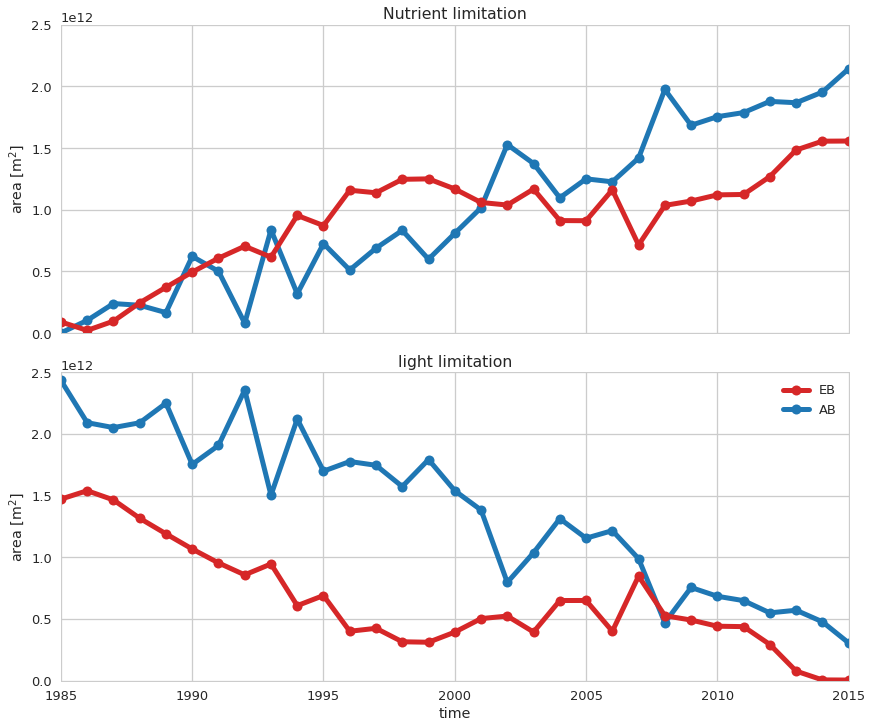

In [17]:
figsize = (12, 10)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, constrained_layout=True, sharex=True)

plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-talk')

df3_yearly_em['nutrient'].plot(kind = 'line',style='.-',markersize = 20, lw = 5, ax = ax1, legend = False, color = 'tab:red', zorder = 2)
df3_yearly_am['nutrient'].plot(kind = 'line',style='.-',markersize = 20, lw = 5, ax = ax1, legend = False, color = 'tab:blue', zorder = 1)
ax1.set_ylabel('area [m$^{2}$]')
ax1.set_title('Nutrient limitation')
ax1.set_ylim(0,2.5e12)

df3_yearly_em['light'].plot(kind = 'line',style='.-',markersize = 20, lw = 5, ax = ax2, legend = False, color = 'tab:red', zorder = 2, label = 'EB')
df3_yearly_am['light'].plot(kind = 'line',style='.-',markersize = 20, lw = 5, ax = ax2, legend = False, color = 'tab:blue', zorder = 1, label = 'AB')
ax2.set_ylabel('area [m$^{2}$]')
ax2.set_title('light limitation')
ax2.set_ylim(0,2.5e12)

plt.legend()

plt.savefig(save_path+'FIG3.png', dpi = 300, bbox_inches='tight') 
plt.savefig(save_path+'FIG3.pdf', dpi = 300, bbox_inches='tight') 

In [86]:
# df3_yearly_em.to_csv('limiting_factors_eurasian.csv')
# df3_yearly_am.to_csv('limiting_factors_amerasian.csv')

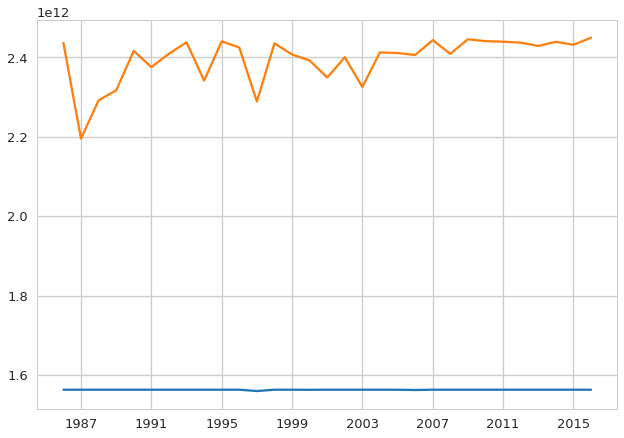

In [87]:
plt.plot(df3_yearly_em['nutrient']+df3_yearly_em['light'])
plt.plot(df3_yearly_am['nutrient']+df3_yearly_am['light'])

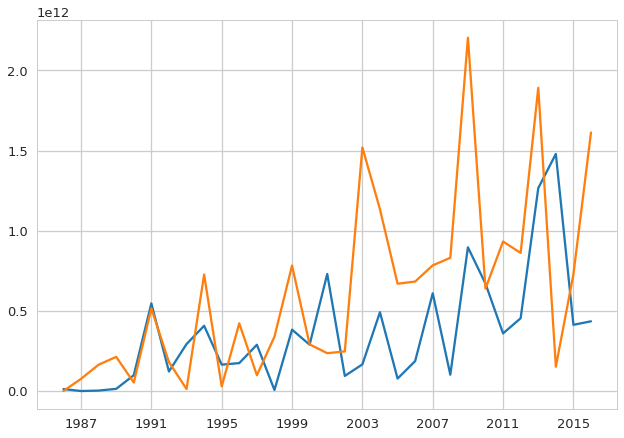

In [88]:
plt.plot(df3_yearly_em['area_np']+df3_yearly_em['area_nd'])
plt.plot(df3_yearly_am['area_np']+df3_yearly_am['area_nd'])
#plt.ylim(0,2.5e12)

# 2D MAP

In [31]:
# dates = pd.date_range('1985', freq="M", periods= 12*len(np.arange(1985,2016,1)))
# data = xr.open_mfdataset(data_path+tracername+'*.nc', concat_dim='time')
# data['time'] = dates
# #data.time.data = dates

# data_sel1 = data.Nlimdia.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
# data_sel1 = data_sel1.compute()

# data_sel2 = data.Nlimphy.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
# data_sel2 = data_sel2.compute()

# data_sel = (data_sel1+data_sel2)/2

# apr_mean = data_sel[data['time.month']==4].mean(dim='time')
# apr_mean = apr_mean.compute()

# may_mean = data_sel[data['time.month']==5].mean(dim='time')
# may_mean = may_mean.compute()

# jun_mean = data_sel[data['time.month']==6].mean(dim='time')
# jun_mean = jun_mean.compute()

# jul_mean = data_sel[data['time.month']==7].mean(dim='time')
# jul_mean = jul_mean.compute()

# aug_mean = data_sel[data['time.month']==8].mean(dim='time')
# aug_mean = aug_mean.compute()

# sept_mean = data_sel[data['time.month']==9].mean(dim='time')
# sept_mean = sept_mean.compute()

# year_mean = (apr_mean+may_mean+jun_mean+jul_mean+aug_mean+sept_mean)/6

# apr = data_sel[data['time.month']==4]
# may = data_sel[data['time.month']==5]
# jun = data_sel[data['time.month']==6]
# jul = data_sel[data['time.month']==7]
# aug = data_sel[data['time.month']==8]
# sep = data_sel[data['time.month']==9]

# year_all = mp.squeeze((apr+may+jun+jul+aug+sep)/6)

# # year = data.sel(time=data.time.dt.month.isin([4, 5, 6, 7, 8, 9]))
# # year = year.compute()

# # year = year.resample(time='YS').mean(dim='time')
# # year = year.compute()

# # year_mean = year.mean(dim='time')
# # year_mean = year_mean.compute()

In [33]:
# np.shape(sep)

(31, 753179)

For depth 0 model level -0.0 will be used
Number of nans in tracer:  0
Number of inf in tracer:  0
Mean of surface:  0.5900374610546185
Max and min:  0.99966961145401 0.012249165214598179


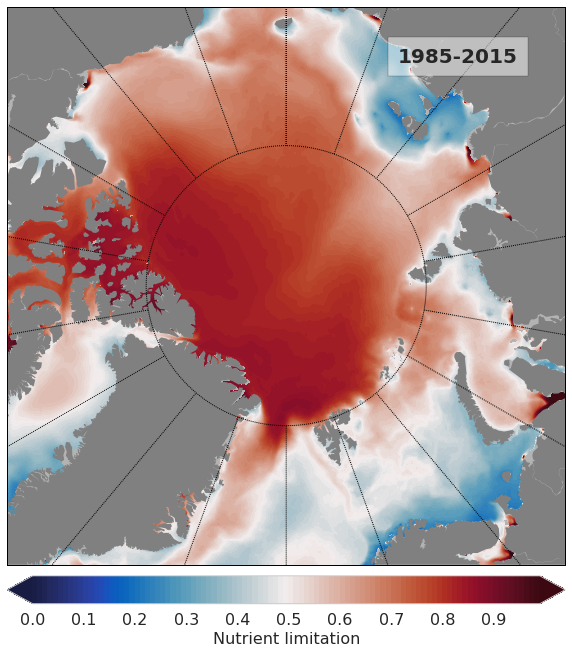

In [22]:
# data, elem_no_nan = pf.get_data(year_mean,mesh,0)

# data2=np.copy(data)
# data2 = data2
# print 'Number of nans in tracer: ',np.count_nonzero(np.isnan(data2))
# print 'Number of inf in tracer: ',np.count_nonzero(np.isinf(data2))
# print 'Mean of surface: ',np.mean(data2)
# print 'Max and min: ',np.max(data2),np.min(data2)

# contours = np.arange(-0, 1, .01)

# fig = plt.figure(figsize=(10, 15), facecolor='w', edgecolor='k')
# #fig.suptitle('Density (kg m$^{-3}$)')
# #fig.subplots_adjust(wspace=0.02,hspace=0.02)

# m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
# x, y = m(mesh.x2, mesh.y2)
# #map.drawcoastlines()
# plabels=[False,False,False,False]
# mlabels=[False,False,False,False]    
# m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
# m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
# m.drawmapboundary(fill_color='0.7')
# m.fillcontinents(color='.5',lake_color='.7')

# #eps=(contours.max()-contours.min())/100.
# #data2[data2<=contours.min()]=contours.min()+eps
# #data2[data2>=contours.max()]=contours.max()-eps

# im=plt.tricontourf(x, y, elem_no_nan, data2, levels=contours, cmap=cmap.cm.balance, extend='both')

# plt.annotate(str(first_year)+'-'+str(last_year), xy=(0.7, 0.9), xycoords='axes fraction', fontsize = 20,
#                      fontweight = 'bold', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

# label = 'Nutrient limitation'
# #plt.title(year)
# cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
# cbar.set_label(label, fontsize=16)
# cbar.ax.tick_params(labelsize=16)

In [34]:
# pff = np.polyfit(years, sep, 1)
# trend = pff[0]

For depth 0 model level -0.0 will be used
Number of nans in tracer:  0
Number of inf in tracer:  0
Mean of surface:  -0.004642094538113458
Max and min:  0.03814661040932125 -0.04172099129627243


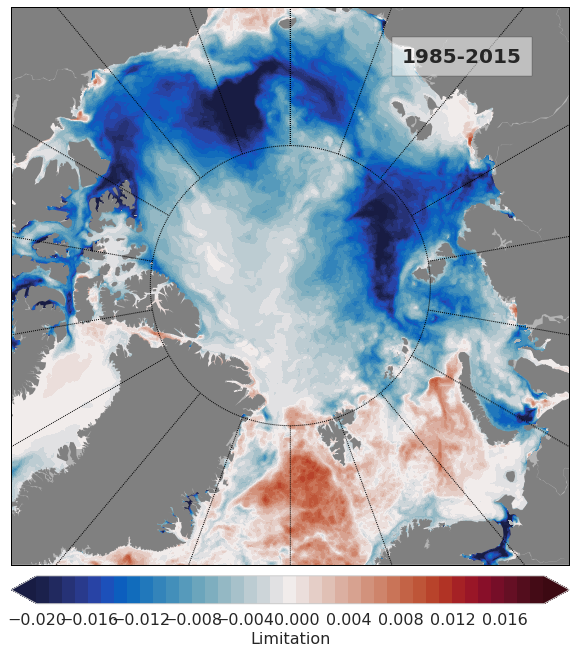

In [35]:
# data, elem_no_nan = pf.get_data(trend,mesh,0)

# data2=np.copy(data)
# data2 = data2
# print 'Number of nans in tracer: ',np.count_nonzero(np.isnan(data2))
# print 'Number of inf in tracer: ',np.count_nonzero(np.isinf(data2))
# print 'Mean of surface: ',np.mean(data2)
# print 'Max and min: ',np.max(data2),np.min(data2)

# contours = np.arange(-0.02, 0.02, .001)

# fig = plt.figure(figsize=(10, 15), facecolor='w', edgecolor='k')
# #fig.suptitle('Density (kg m$^{-3}$)')
# #fig.subplots_adjust(wspace=0.02,hspace=0.02)

# m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
# x, y = m(mesh.x2, mesh.y2)
# #map.drawcoastlines()
# plabels=[False,False,False,False]
# mlabels=[False,False,False,False]    
# m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
# m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
# m.drawmapboundary(fill_color='0.7')
# m.fillcontinents(color='.5',lake_color='.7')

# #eps=(contours.max()-contours.min())/100.
# #data2[data2<=contours.min()]=contours.min()+eps
# #data2[data2>=contours.max()]=contours.max()-eps

# im=plt.tricontourf(x, y, elem_no_nan, data2, levels=contours, cmap=cmap.cm.balance, extend='both')

# plt.annotate(str(first_year)+'-'+str(last_year), xy=(0.7, 0.9), xycoords='axes fraction', fontsize = 20,
#                      fontweight = 'bold', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

# label = 'Limitation'
# #plt.title(year)
# cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
# cbar.set_label(label, fontsize=16)
# cbar.ax.tick_params(labelsize=16)